In [154]:
import pandas as pd
import numpy as np

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import re

from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

from IPython.display import display 

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

sns.set(context = 'notebook', style = 'whitegrid')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [150]:
def graph_model_history(history):
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1,2, figsize = (10,5))
    axes[0].plot(history.history['acc'], label = 'Train Accuracy')
    axes[0].plot(history.history['val_acc'], label = 'Validation Accuracy')
    axes[0].legend()
    axes[1].plot(history.history['loss'], label = 'Train Loss')
    axes[1].plot(history.history['val_loss'], label = 'Validation Loss')
    axes[1].legend()
    plt.show()

In [151]:
def plot_confusion_matrix(y_true,y_pred):
    import seaborn as sns

    sns.heatmap(confusion_matrix(y_true, y_pred, normalize = 'true'), 
            annot = True, 
            xticklabels = ['Negative','Neutral','Positive'],
            yticklabels = ['Negative','Neutral','Positive'])
    plt.xlabel = 'Predicted Sentiment'
    plt.ylabel = 'True Sentiment'
    plt.show()

In [37]:
df = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
df.columns = ['text', 'target', 'emotion']

df = df[df['emotion'] != 'I can\'t tell'] #engineering choice
df['target'].replace(['iPad', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'], 
                     'Apple', inplace = True) #engineering choice
df['target'].replace(['Other Google product or service'], 'Google', inplace = True)
df['target'].replace(['Android App'], 'Android', inplace = True)

df['target'].fillna('No Target', inplace = True)
df.dropna(inplace = True)


In [175]:
sw = stopwords.words('english')
sw.extend(['link', 'rt', 'sxsw','http'])
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!'
twitter_re = re.compile('[#@][a-zA-Z]*')
num_re = re.compile('^\d{1}$')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def txt_clean(txt, stop_words=sw):
    t = txt.split(' ')
    t = [w.lower() for w in t]
    t = [w.translate(w.maketrans('','', punctuation)) for w in t]
    t = [w for w in t if not twitter_re.match(w)]
    t = [w for w in t if not num_re.match(w)]
    t = [w for w in t if w not in stop_words]
    t = [w for w in t if w]
    t = pos_tag(t)
    t = [(w[0], get_wordnet_pos(w[1])) for w in t]
    lem = WordNetLemmatizer()
    t = [lem.lemmatize(w[0], w[1]) for w in t]
    return ' '.join(t)

df['txt_cleaned'] = df['text'].map(txt_clean)

# Data Preprocessing 

In [159]:
sequence_len = 128

X = df['txt_cleaned']
y = df['emotion']

# binarizer = LabelBinarizer()
# y = pd.DataFrame(binarizer.fit_transform(y), columns = binarizer.classes_)
encoder = LabelEncoder()
tokenizer = text.Tokenizer()
sm = SMOTE()


y = pd.DataFrame(encoder.fit_transform(y))


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.25)

tokenizer.fit_on_texts(list(X_train))
list_tokenized_headlines = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

tokenized_X_t = tokenizer.texts_to_sequences(X_t)
X_t = sequence.pad_sequences(tokenized_X_t, maxlen=128)

X_t_res, y_t_res = sm.fit_sample(X_t,y_t)

tokenized_X_val = tokenizer.texts_to_sequences(X_val)
X_val = sequence.pad_sequences(tokenized_X_val, maxlen=128)

tokenized_X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_X_test, maxlen=128)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([[   0,    0,    0, ...,   15,   42,   14],
       [   0,    0,    0, ...,   61,  895,  801],
       [   0,    0,    0, ...,   27,  166,  176],
       ...,
       [   0,    0,    0, ..., 1680,  513,  176],
       [   0,    0,    0, ...,  255,    5,  621],
       [   0,    0,    0, ..., 2801,    5,   99]], dtype=int32)

In [172]:
list_tokenized_headlines

[[46, 31, 1, 23],
 [3708, 5, 9, 4, 107, 184, 261, 697],
 [521, 217, 37, 39, 32, 1, 173, 356, 617, 1063, 413],
 [1926, 1927, 3709, 2, 3710, 3711, 1363, 2512, 73],
 [57, 53, 1, 142, 117, 10, 212, 118, 26],
 [237,
  1,
  38,
  357,
  26,
  1364,
  70,
  32,
  1,
  38,
  26,
  70,
  455,
  2513,
  742,
  73,
  1,
  38,
  292],
 [185, 8, 176, 1588, 37, 293, 197],
 [74, 2, 964, 414, 3, 4, 55, 1194, 163],
 [1, 38, 26, 32, 1195, 174, 807, 3712],
 [11, 965, 58, 195, 20, 9],
 [79, 146, 294, 198, 41, 90, 2514, 1589, 2515, 808, 966, 2],
 [1928, 198, 316, 5, 3713, 317],
 [1, 3714, 1365, 3715],
 [2516, 68, 3, 549, 33, 4, 44, 8, 2, 7],
 [54, 3716, 1366, 226, 41, 655, 158],
 [83, 96, 967, 41, 66, 29, 743, 205, 72, 1, 10, 3717, 274],
 [1, 7, 30, 6, 12, 17, 22, 15, 42, 14, 108],
 [372, 550, 3718, 415, 182, 1, 1367, 77, 68, 1929, 115],
 [84, 90, 28, 2517, 397, 1930, 186, 744, 247, 2, 302, 3, 4, 1064],
 [109, 385, 28, 1, 57, 53],
 [522, 474, 698, 227, 2, 398, 339, 2518, 93, 2519, 3719, 3720],
 [19, 95, 8,

## Model 1
RNN First Simple Model, no SMOTE

In [147]:
def make_model1():
    embedding_size = 128
    model1 = Sequential()
    model1.add(Embedding(len(tokenizer.word_index.keys())+1, sequence_len))
    model1.add(LSTM(25, return_sequences=True))
    model1.add(GlobalMaxPool1D())
    model1.add(Dropout(0.5))
    model1.add(Dense(50, activation='relu'))
    model1.add(Dropout(0.5))
    model1.add(Dense(3, activation='softmax'))

    model1.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model1

Epoch 1/11
101/101 [==============================] - 2s 19ms/step - loss: 0.9086 - acc: 0.5740 - val_loss: 0.8397 - val_acc: 0.5990
Epoch 2/11
101/101 [==============================] - 2s 15ms/step - loss: 0.8634 - acc: 0.6003 - val_loss: 0.8211 - val_acc: 0.5990
Epoch 3/11
101/101 [==============================] - 1s 15ms/step - loss: 0.8094 - acc: 0.6299 - val_loss: 0.7761 - val_acc: 0.6593
Epoch 4/11
101/101 [==============================] - 1s 14ms/step - loss: 0.7146 - acc: 0.7039 - val_loss: 0.7883 - val_acc: 0.6134
Epoch 5/11
101/101 [==============================] - 1s 15ms/step - loss: 0.6440 - acc: 0.7511 - val_loss: 0.7628 - val_acc: 0.6653
Epoch 6/11
101/101 [==============================] - 1s 14ms/step - loss: 0.5813 - acc: 0.7768 - val_loss: 0.7691 - val_acc: 0.6647
Epoch 7/11
101/101 [==============================] - 1s 15ms/step - loss: 0.5360 - acc: 0.7951 - val_loss: 0.7757 - val_acc: 0.6695
Epoch 8/11
101/101 [==============================] - 1s 15ms/step - 

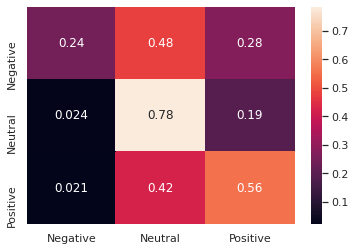

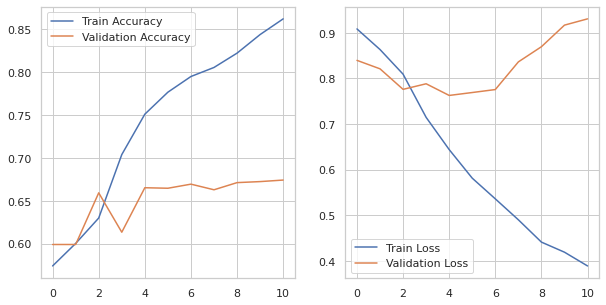

model validation accuracy is: 0.6742243436754176


In [152]:
model1 = KerasClassifier(build_fn = make_model1, 
                         epochs = 11, 
                         batch_size = 50, 
                         validation_data = (X_val,y_val))

history = model1.fit(X_t, y_t)
y_pred = model1.predict(X_val)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val,y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val,y_pred)}')

### Model 1 Evaluation
Model 1 overfits after 11 epochs.  It reaches 67% accuracy on the validation set at the point.  It struggles to classify negative emotions, and to a lesser degree positives.  Because of the class imbalance skewed toward no emotion, it overpredicts this class.

## Model 2
for model 2 I will try the same as model 1, but with SMOTED class balances.

In [173]:
def make_model2():
    embedding_size = 128
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index.keys())+1, sequence_len))
    model.add(LSTM(25, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

Epoch 1/20
182/182 [==============================] - 3s 17ms/step - loss: 1.0920 - acc: 0.3742 - val_loss: 1.0595 - val_acc: 0.4958
Epoch 2/20
182/182 [==============================] - 3s 14ms/step - loss: 1.0271 - acc: 0.4879 - val_loss: 1.0209 - val_acc: 0.4749
Epoch 3/20
182/182 [==============================] - 2s 14ms/step - loss: 0.9420 - acc: 0.5620 - val_loss: 0.9926 - val_acc: 0.5322
Epoch 4/20
182/182 [==============================] - 2s 14ms/step - loss: 0.8626 - acc: 0.6237 - val_loss: 0.9372 - val_acc: 0.5805
Epoch 5/20
182/182 [==============================] - 3s 14ms/step - loss: 0.7863 - acc: 0.6699 - val_loss: 1.0682 - val_acc: 0.5400
Epoch 6/20
182/182 [==============================] - 3s 14ms/step - loss: 0.7260 - acc: 0.7052 - val_loss: 0.9925 - val_acc: 0.5919
Epoch 7/20
182/182 [==============================] - 3s 14ms/step - loss: 0.6642 - acc: 0.7330 - val_loss: 1.0783 - val_acc: 0.5579
Epoch 8/20
182/182 [==============================] - 2s 14ms/step - 

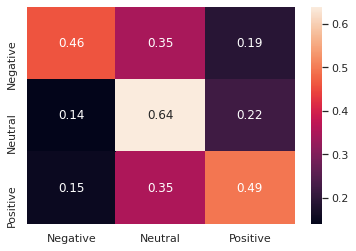

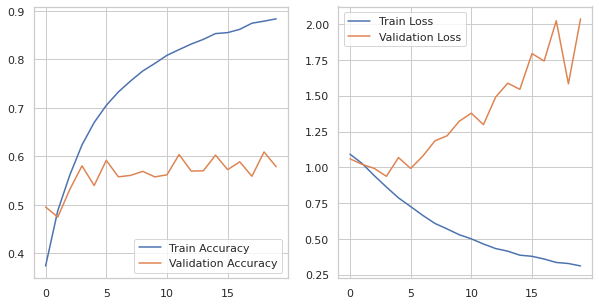

model validation accuracy is: 0.5787589498806682


In [174]:
model2 = KerasClassifier(build_fn = make_model2, 
                         epochs = 20, 
                         batch_size = 50, 
                         validation_data = (X_val,y_val))
history = model2.fit(X_t_res, y_t_res)
y_pred = model2.predict(X_val)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val,y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val,y_pred)}')

### Model 2 Evaluation:
Model 2 begins overfitting at about 6 epochs.  The overall accuracy is lower, but the true positive rates are more balanced between the classes.  False positives are still high for no emotion